# Lab 5 : Mixture Models+Model orden selection 

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD5"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L5_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

In [39]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

class MyGMM:
    
    def __init__(self, k):
        """
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array containing covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        """
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, tol=1e-3, max_iter=1000):
        """
        Fit the GMM model to the data
        
        Parameters:
        X: (n, p) np.array
            Data matrix
        
        tol: float
            Convergence tolerance
        
        max_iter: int
            Maximum number of iterations
        
        Returns:
        self
        """
        n, p = X.shape
        kmeans = KMeans(n_clusters=self.k, random_state=0).fit(X)
        self.alpha_ = np.ones(self.k) / self.k
        self.mu_ = kmeans.cluster_centers_
        self.Sigma_ = np.array([np.cov(X.T) + 1e-6 * np.eye(p) for _ in range(self.k)]) 
        
        def compute_conditional_prob_matrix(X, alpha, mu, Sigma):
            '''Compute the conditional probability matrix shape: (n, K)'''
            n = X.shape[0]
            cond_prob = np.zeros((n, self.k))
            for j in range(self.k):
                rv = multivariate_normal(mean=mu[j], cov=Sigma[j])
                cond_prob[:, j] = alpha[j] * rv.pdf(X)
            cond_prob /= cond_prob.sum(axis=1, keepdims=True)
            return cond_prob

        for i in range(max_iter):
            cond_prob_prev = self.cond_prob_ if self.cond_prob_ is not None else np.zeros((n, self.k))
            self.cond_prob_ = compute_conditional_prob_matrix(X, self.alpha_, self.mu_, self.Sigma_)

            Nk = self.cond_prob_.sum(axis=0)
            self.alpha_ = Nk / n
            self.mu_ = (self.cond_prob_.T @ X) / Nk[:, np.newaxis]
            for j in range(self.k):
                diff = X - self.mu_[j]
                self.Sigma_[j] = (self.cond_prob_[:, j][:, np.newaxis] * diff).T @ diff / Nk[j]
                self.Sigma_[j] += 1e-6 * np.eye(p)  # Add regularization to prevent singular matrices

            if np.linalg.norm(self.cond_prob_ - cond_prob_prev) < tol:
                break
        
        return self
    
    def predict(self, X):
        """
        Predict labels for X
        
        Parameters:
        X: (n, p) np.array
            New data matrix
        
        Returns:
        labels: (n, ) np.array
            Label assignments        
        """
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        return self.labels_
        
    def compute_proba(self, X):
        """
        Compute probability vector for X
        
        Parameters:
        X: (n, p) np.array
            New data matrix
        
        Returns:
        proba: (n, k) np.array        
        """
        return self.cond_prob_


Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

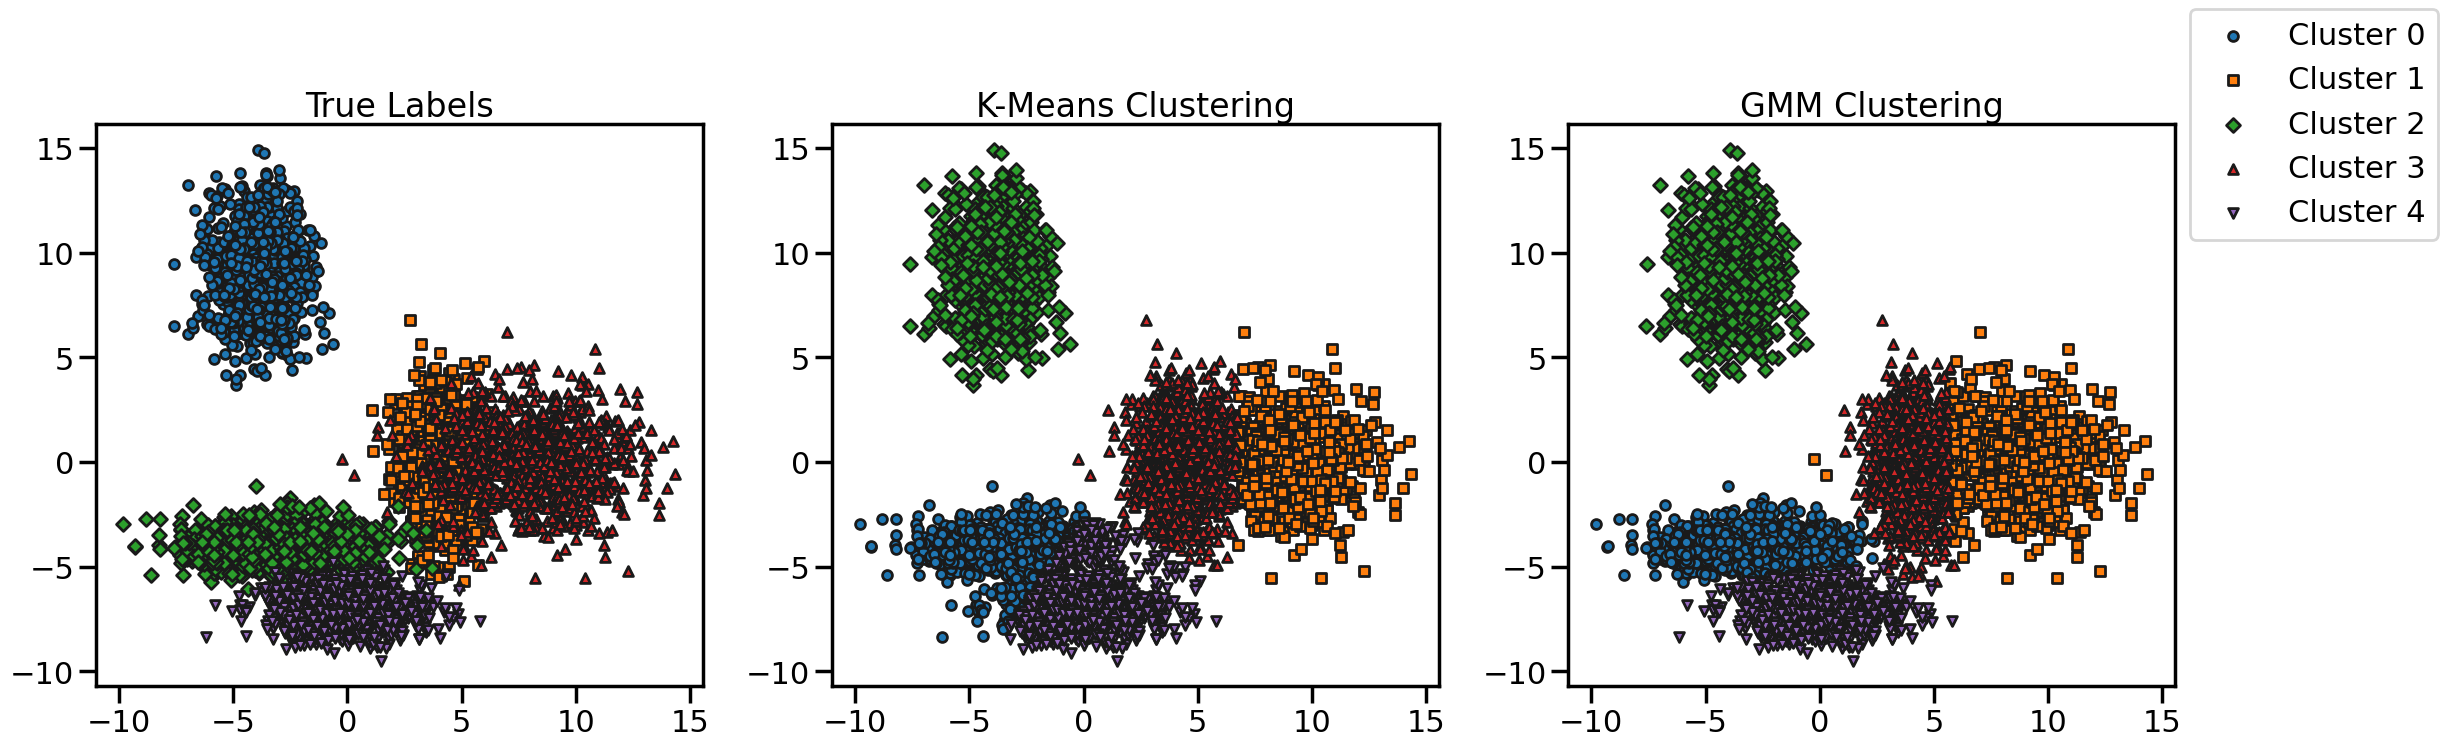

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# Generate a synthetic dataset with five Gaussian distributions
np.random.seed(42)  # For reproducibility

n_clusters = 5
dimension = 2
mus = np.random.randint(-10, 10, (n_clusters, dimension))
sigmas = np.array([np.diag(np.random.uniform(0.5, 5, dimension)) for _ in range(n_clusters)])
n = 1000
X = np.concatenate([np.random.multivariate_normal(mus[i], sigmas[i], n) for i in range(n_clusters)])
y_true = np.concatenate([np.ones(n) * i for i in range(n_clusters)])  # True labels for each point

# Fit our custom GMM (assuming MyGMM is already defined and implemented)
gmm = MyGMM(k=n_clusters)
gmm.fit(X)
y_pred_gmm = gmm.predict(X)

# Fit K-Means for comparison
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_pred_kmeans = kmeans.labels_

# Function to plot ellipses for GMM
def plot_ellipse(mean, cov, ax, **kwargs):
    v, w = np.linalg.eigh(cov)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = np.degrees(angle)
    v = 2. * np.sqrt(2.) * np.sqrt(v)  # Scale eigenvalues for 95% confidence ellipse
    ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, **kwargs)
    ax.add_patch(ell)

# Plotting the data with three subplots
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

# 1. Plot True Labels
for i, shape in zip(range(n_clusters), ['o', 's', 'D', '^', 'v']):
    ax[0].scatter(X[y_true == i, 0], X[y_true == i, 1], edgecolor='k', marker=shape, label=f'Cluster {i}', s=50)
ax[0].set_title('True Labels')
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend outside plot

# 2. Plot K-Means predictions
for i, shape in zip(range(n_clusters), ['o', 's', 'D', '^', 'v']):
    ax[1].scatter(X[y_pred_kmeans == i, 0], X[y_pred_kmeans == i, 1], edgecolor='k', marker=shape, label=f'Cluster {i}', s=50)
ax[1].set_title('K-Means Clustering')
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend outside plot

# 3. Plot GMM predictions with ellipses
for i in range(n_clusters):
    plot_ellipse(gmm.mu_[i], gmm.Sigma_[i], ax[2], alpha=0.2, color=f'C{i}')
for i, shape in zip(range(n_clusters), ['o', 's', 'D', '^', 'v']):
    ax[2].scatter(X[y_pred_gmm == i, 0], X[y_pred_gmm == i, 1], edgecolor='k', marker=shape, label=f'Cluster {i}', s=50)
ax[2].set_title('GMM Clustering')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend outside plot

plt.tight_layout()
plt.show()


=> GMM has outperformed KMeans in clustering our data due to its ability to model each cluster as a mixture of Gaussian distributions. This approach allows GMM to capture the underlying distribution of the clusters more effectively, whereas KMeans relies solely on a distance-based approach.

**Exploring the probabilities of belonging to each cluster**

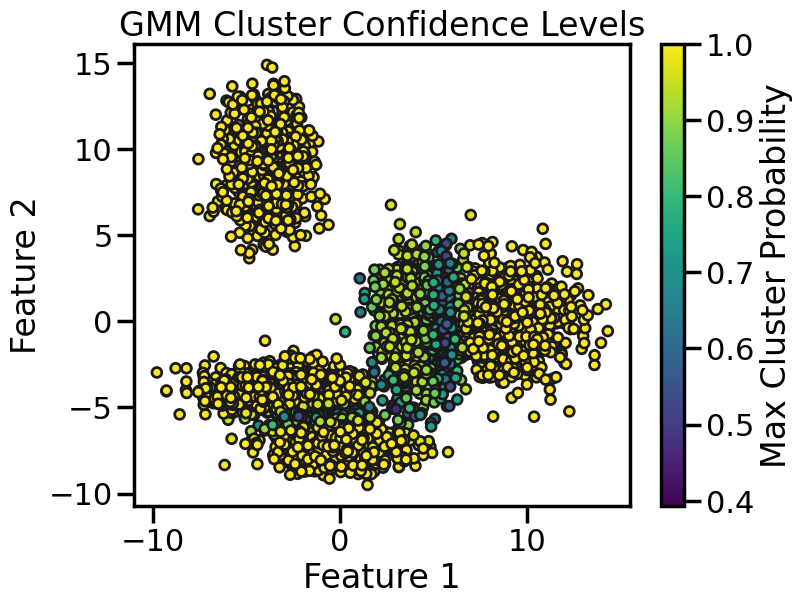

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Compute maximum probabilities for each point
max_probs = np.max(gmm.cond_prob_, axis=1)

# Plot points, color-coded by confidence (probability)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=max_probs, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Max Cluster Probability')
plt.title('GMM Cluster Confidence Levels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

=> For five clusters, we observe that GMM shows the least confidence in classifying data points that fall within overlapping clusters. While GMM may misclassify some points, it still offers advantages over a basic KMeans algorithm, which simply assigns clusters. GMM allows for greater flexibility by enabling us to modify our clustering approach through the adjustment of a probability threshold if desired.

**Trying for a bigger number of clusters**

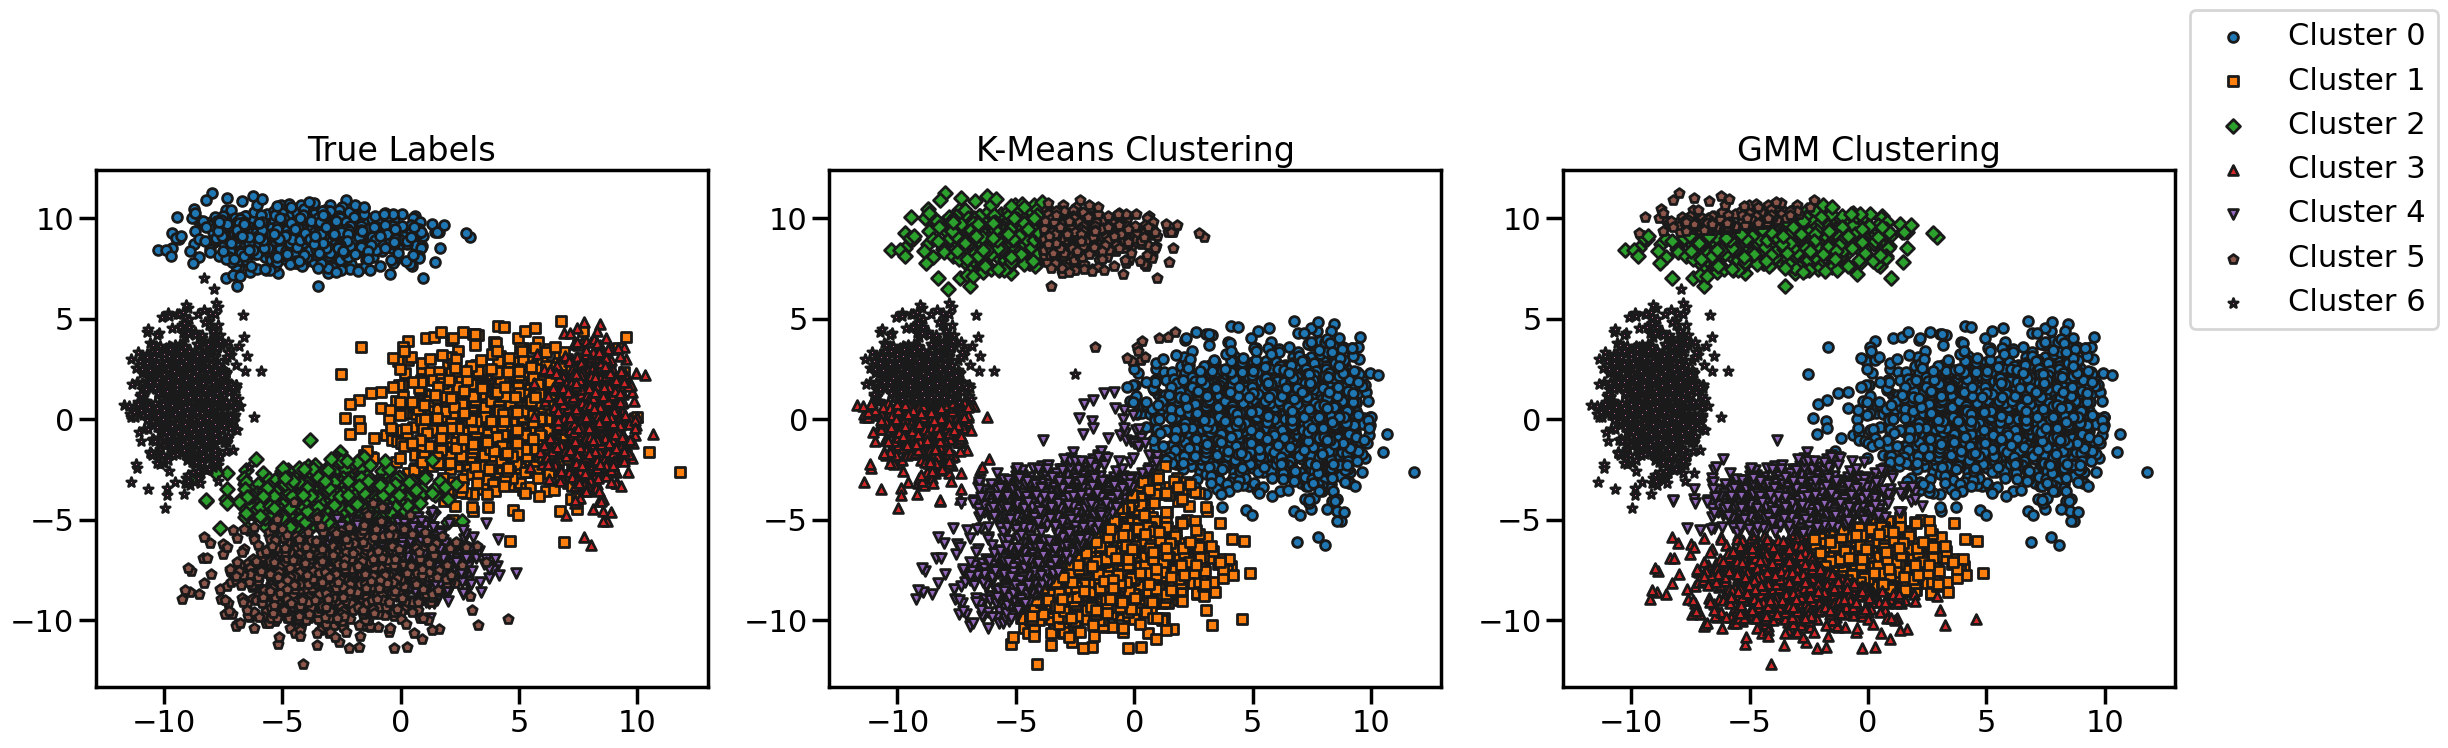

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# Generate a synthetic dataset with five Gaussian distributions
np.random.seed(42)  # For reproducibility

n_clusters = 7
dimension = 2
mus = np.random.randint(-10, 10, (n_clusters, dimension))
sigmas = np.array([np.diag(np.random.uniform(0.5, 5, dimension)) for _ in range(n_clusters)])
n = 1000
X = np.concatenate([np.random.multivariate_normal(mus[i], sigmas[i], n) for i in range(n_clusters)])
y_true = np.concatenate([np.ones(n) * i for i in range(n_clusters)])  # True labels for each point

# Fit our custom GMM (assuming MyGMM is already defined and implemented)
gmm = MyGMM(k=n_clusters)
gmm.fit(X)
y_pred_gmm = gmm.predict(X)

# Fit K-Means for comparison
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
y_pred_kmeans = kmeans.labels_

# Function to plot ellipses for GMM
def plot_ellipse(mean, cov, ax, **kwargs):
    v, w = np.linalg.eigh(cov)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = np.degrees(angle)
    v = 2. * np.sqrt(2.) * np.sqrt(v)  # Scale eigenvalues for 95% confidence ellipse
    ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle, **kwargs)
    ax.add_patch(ell)

# Plotting the data with three subplots
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

# 1. Plot True Labels
for i, shape in zip(range(n_clusters), ['o', 's', 'D', '^', 'v', 'p', '*']):
    ax[0].scatter(X[y_true == i, 0], X[y_true == i, 1], edgecolor='k', marker=shape, label=f'Cluster {i}', s=50)
ax[0].set_title('True Labels')
#ax[0].legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend outside plot

# 2. Plot K-Means predictions
for i, shape in zip(range(n_clusters), ['o', 's', 'D', '^', 'v', 'p', '*']):
    ax[1].scatter(X[y_pred_kmeans == i, 0], X[y_pred_kmeans == i, 1], edgecolor='k', marker=shape, label=f'Cluster {i}', s=50)
ax[1].set_title('K-Means Clustering')
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend outside plot

# 3. Plot GMM predictions with ellipses
for i in range(n_clusters):
    plot_ellipse(gmm.mu_[i], gmm.Sigma_[i], ax[2], alpha=0.2, color=f'C{i}')
for i, shape in zip(range(n_clusters), ['o', 's', 'D', '^', 'v', 'p', '*']):
    ax[2].scatter(X[y_pred_gmm == i, 0], X[y_pred_gmm == i, 1], edgecolor='k', marker=shape, label=f'Cluster {i}', s=50)
ax[2].set_title('GMM Clustering')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 1))  # Move legend outside plot

plt.tight_layout()
plt.show()


=> The plot shows that GMM struggles to correctly classify all points when clustering into 7 groups, resulting in notable misclassifications. This outcome likely arises from limitations in GMM’s assumption that each cluster follows a Gaussian distribution. As clusters increase, overlapping boundaries and proximity between clusters make it harder for GMM to distinguish between them. Additionally, with more clusters, parameter estimation for each Gaussian component becomes less stable, leading to errors in cluster assignments. These issues highlight the model’s difficulty in accurately capturing complex, overlapping data structures.

**Exploring the probabilities of belonging to each cluster**

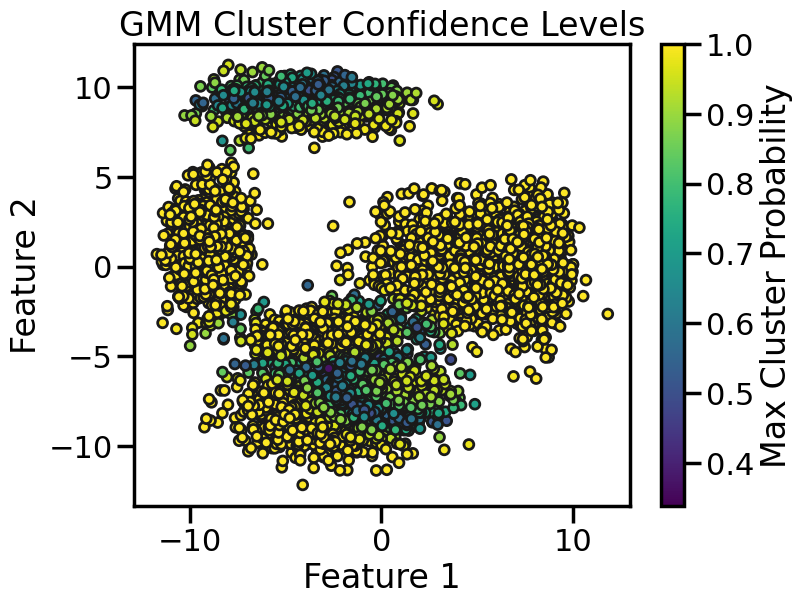

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Compute maximum probabilities for each point
max_probs = np.max(gmm.cond_prob_, axis=1)

# Plot points, color-coded by confidence (probability)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=max_probs, cmap='viridis', edgecolor='k', s=50)
plt.colorbar(label='Max Cluster Probability')
plt.title('GMM Cluster Confidence Levels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


When applying a Gaussian Mixture Model (GMM) with seven clusters to a dataset, we observe that the algorithm exhibited low confidence in classifying data points within certain overlapping clusters. Conversely, in other overlapping regions, the model displays high confidence, often assigning points from multiple clusters to a single cluster.

The results indicate that GMM struggles with ambiguity in areas where cluster boundaries overlap, leading to low confidence in classification for some points. However, in other overlapping regions, the algorithm demonstrates high confidence by clustering points into a single group, suggesting that their features align closely with one distribution. This dual behavior may highlight both the model's ability to capture complex relationships in the data and the possibility of insufficient cluster differentiation, indicating that some clusters may not be as distinct as initially defined.

**Comparaison with the previous results**

When comparing the results of the GMM with seven clusters to those with five clusters, the behavior of the model reveals key differences in confidence regarding overlapping clusters. With five clusters, the GMM consistently shows low confidence when data points fall within overlapping regions, suggesting that the model recognizes the significant ambiguity and uncertainty in these areas. In contrast, with seven clusters, the model exhibits a more varied response: while it still demonstrates low confidence for certain overlapping clusters, it also identifies other regions where data points are assigned with high confidence to a single cluster, even in the presence of overlap. This shift suggests that the increased number of clusters allows the GMM to better capture and differentiate complex structures in the data, potentially leading to clearer distinctions in some cases. However, it also highlights the risk of model complexity, where some clusters may still lack clear separation, emphasizing the need for careful analysis of the underlying data and consideration of the optimal number of clusters.